<a href="https://colab.research.google.com/github/WittyTheMighty/ML-kaggle/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Final Kaggle competition ML

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [326]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torchvision as  tv
import torch.nn as nn
import torchvision.transforms as transforms
import os
import pandas as pd
import pickle as pkl
from matplotlib import cm
from PIL import Image
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import csv
import scipy as sp
import copy


In [7]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

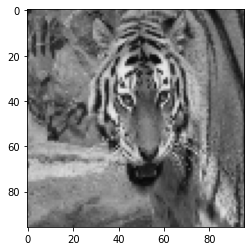

In [127]:
PATH = '/drive/MyDrive/ML-Kaggle/'
PATH = "/content/drive/MyDrive/ML-Kaggle/"
# PATH = '../data/'

x_train_scalar = np.array(pkl.load(open(PATH+'x_train.pkl', 'rb')))
y_train = np.array(pkl.load(open(PATH+'y_train.pkl', 'rb')))
x_test =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))

x_train = []

for image in x_train_scalar:
    imge_out = Image.fromarray(image.astype('uint8'))
    img_as_img = imge_out.convert("RGB")
    x_train.append(np.array(img_as_img))
    
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))

plt.imshow(np.transpose(x_train[0], (1, 2 , 0)))

In [ ]:
labels = np.unique(y_train)
labels = dict(zip(labels, range(len(labels))))
labels

In [191]:
type(x_train)

numpy.ndarray

---

## Hyperparameters

In [96]:
batch_size = 64
num_epochs = 20

#pooling
pooling_filter_size = 2
pooling_stride = 2

#k-fold-validation
k_folds = 5


---

## Preprocessing

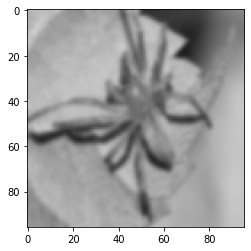

In [325]:
#First preprocessing step 

#Utilitary function for geometric preprocessing
X_flipped = flip_image_flip_verticaly(x_train[0])


def flip_horizontaly(X):
    flipped_image = copy.deepcopy(X)
    for idx,channel in enumerate(flipped_image):
        flipped_image[idx]= np.fliplr(channel)

    return flipped_image

def rotate90(X):
    rot90_img = copy.deepcopy(X)
    for idx,channel in enumerate(rot90_img):
        rot90_img[idx]= np.rot90(channel)
    return rot90_img

def rotate(degree,X):
    rot_img = copy.deepcopy(X)
    for idx,channel in enumerate(rot_img):
        rot_img[idx]= sp.ndimage.rotate(channel, degree, reshape=False)
    return rot_img

#An adaptation from:
# https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
def clipped_zoom(img, zoom_factor):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = sp.ndimage.zoom(img, zoom_tuple)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = sp.ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

def blur(X,blur_factor):
    blur_img = copy.deepcopy(X)
    for idx,channel in enumerate(blur_img):
        blur_img[idx]= sp.ndimage.gaussian_filter(channel, sigma=blur_factor)
    return blur_img

plt.imshow(np.transpose(blur(x_train[5],0.9),(1,2,0)))

---
## Model

In [ ]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda')
#device = torch.device("cpu")

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.utils as vutils

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
    

y_train = [labels[y] for y in y_train]
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0, random_state=4)

x_train_tensor = torch.tensor(x_train, dtype=float)
y_train_tensor = torch.tensor(y_train, dtype=float)

trans = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_dataset = CustomTensorDataset(tensors=(x_train_tensor, y_train_tensor), transform=trans)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False)

#x_train_tensor.shape
real_batch = next(iter(train_dataloader))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
conv1 = nn.Conv2d(3,6,5)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(6,16,5)
images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)
print("")

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)
print("")

x = pool(x)
print("POOL2")
print(x.shape)
print("")

In [ ]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(6,16,5) 
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(16*21*21, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*21*21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [ ]:
conv1 = nn.Conv2d(3,6,3)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(6,16,5)
conv3 = nn.Conv2d(16,26,7)
images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

x = conv3(x)
print("CONV3")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

In [ ]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv3 = nn.Conv2d(16,26,7)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(26*7*7, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [ ]:
# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

running_loss = 0 
printfreq = 25

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=batch_size, sampler=test_subsampler)
    
    network = Net().to(device)
    network.apply(reset_weights)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()
            optimizer.zero_grad()
            outputs = network(inputs)  # forward pass 
            outputs = outputs.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            if i % printfreq == printfreq - 1 :
                print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / printfreq))
                current_loss = 0.0
         # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)
    
    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data
        
        inputs = inputs.float().to(device)
        targets = targets.to(device)

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

In [ ]:
network = Net()
network.load_state_dict(torch.load('./model-fold-2.pth'))
network.eval()

In [ ]:
x_test_tensor = torch.tensor(x_test, dtype=float)
y_test_tensor = torch.tensor(y_test, dtype=float)

test_dataset = CustomTensorDataset(tensors=(x_test_tensor, y_test_tensor), transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [ ]:
numberOfBatches = 0
totalAccuracy = 0

for i, data in enumerate(test_dataloader):
    numberOfBatches += 1
    inputs, labels = data
    
    outputs = network(inputs.float())
    
    print(outputs.shape)

    preds = outputs.argmax(dim=1).cpu()
    
    print(preds.shape)
    print(preds)
    print(labels.shape)
    print(labels)
    print("")

    totalAccuracy += accuracy_score(labels.cpu(), preds.cpu())

print(totalAccuracy / numberOfBatches)

In [ ]:
def make_submission(x_test, network):
    header = ["Id", "class"]
    id_value = 0
    
    classifications =[]
    for image in tqdm.tqdm(x_test):
        image = torch.reshape(image, (1, 3, 96, 96))
        classifications.append([id_value, network(image.float()).argmax(dim=1)[0].item()])
        id_value += 1
    
    y = "./submission.csv"
    with open(y, 'w', newline='') as work:
        z = csv.writer(work)
        z.writerow(header)
        z.writerows(classifications)

In [ ]:
x_test_scalar =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))

x_test = []

for image in x_test_scalar:
    imge_out = Image.fromarray(image.astype('uint8'))
    img_as_img = imge_out.convert("RGB")
    x_test.append(np.array(img_as_img))
    

x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))

x_test = torch.tensor(x_test, dtype=float)

network = Net()
network.load_state_dict(torch.load('./model-fold-2.pth'))
network.eval()

make_submission(x_test, network)